Dogs vs Cats Image Classification Without and with Image Augmentation and Drop Out to prevent overfitting
---------------------------------------------------------------------------------------------------------------
Classifying Images into pictures of cats and dogs.

Built Image Classifier using tf.keras.Sequential model and load data using tf.keras.preprocessing.image.ImageDataGenerator - How can we efficiently work with data on disk to interface with our model?

Overfitting - what is it, how to identify it?

Importing packages
-----------------------
Let's start by importing required packages:

os — to read files and directory structure
numpy — for some matrix math outside of TensorFlow
matplotlib.pyplot — to plot the graph and display images in our training and validation data

In [4]:
import tensorflow as tf

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Data Loading
-------------

The dataset we are using is a filtered version of Dogs vs. Cats dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

Used the class tf.keras.preprocessing.image.ImageDataGenerator which will read data from disk. We therefore need to directly download Dogs vs. Cats from a URL and unzip it to the Colab filesystem.

In [13]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

We can list the directories with the following terminal command:

In [12]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


We'll now assign variables with the proper file path for the training and validation sets.

In [14]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

Understanding data

Let's look at how many cats and dogs images we have in our training and validation directory

In [15]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [16]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


Setting Model Parameters
---------------------------
For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [17]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [18]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk, apply rescaling, and resize them using single line of code.

In [19]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [20]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


Visualizing Training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using `matplotlib`.

In [21]:
sample_training_images, _ = next(train_data_gen) 

The `next` function returns a batch from the dataset. One batch is a tuple of (*many images*, *many labels*). For right now, we're discarding the labels because we just want to look at the images.

In [22]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

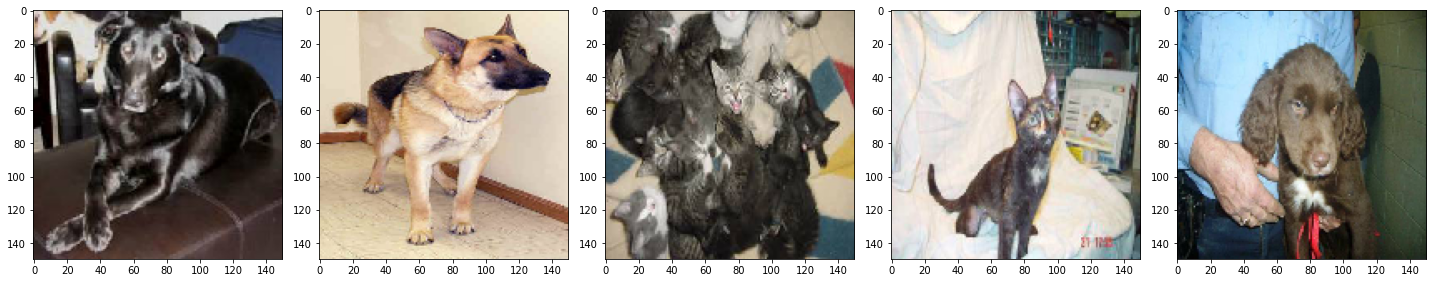

In [23]:
plotImages(sample_training_images[:5])  # Plot images 0-4

Model Creation
--------------------

Define the model
----------------------

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax.


In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

Compile the model
---------------------
As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
### Model Summary

#Let's look at all the layers of our network using **summary** method.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

Train the model
--------------------

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [27]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 10s 509ms/step - loss: 0.7460 - accuracy: 0.5140 - val_loss: 0.6883 - val_accuracy: 0.6220
Epoch 2/100
20/20 [==============================] - 10s 499ms/step - loss: 0.6832 - accuracy: 0.5720 - val_loss: 0.6644 - val_accuracy: 0.5960
Epoch 3/100
20/20 [==============================] - 10s 500ms/step - loss: 0.6624 - accuracy: 0.6050 - val_loss: 0.6476 - val_accuracy: 0.6430
Epoch 4/100
20/20 [==============================] - 10s 489ms/step - loss: 0.6482 - accuracy: 0.6175 - val_loss: 0.6274 - val_accuracy: 0.6440
Epoch 5/100
20/20 [==============================] - 10s 495ms/step - loss: 0.6075 - accuracy: 0.6750 - val_loss: 0.6085 - val_accuracy: 0.6680
Epoch 6/100
20/20 [==============================] - 10s 497ms/step - loss: 0.5619 - accuracy: 0.7205 - val_loss: 0.6222 - val_accuracy: 0.6730
Epoch 7/100
20/20 [==============================] - 10s 494ms/step - loss: 0.5177 - accuracy: 0.7355 - val_loss: 0.5452 - val_accuracy:

Visualize results of the training
------------------------------------

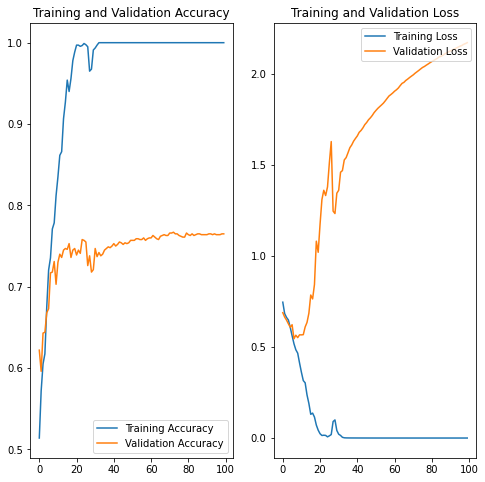

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by large margin and our model has achieved only around **70%** accuracy on the validation set (depending on the number of epochs you trained for).

This is a clear indication of overfitting. Once the training and validation curves start to diverge, our model has started to memorize the training data and is unable to perform well on the validation data.

Image Classification with Image Augmentation techniques to prevent overfitting
----------------------------------------------------------------------------------

Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [29]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Flipping the image horizontally
-------------------------------------
We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation. This is achieved by passing `horizontal_flip=True` as an argument to the `ImageDataGenerator` class.

In [30]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

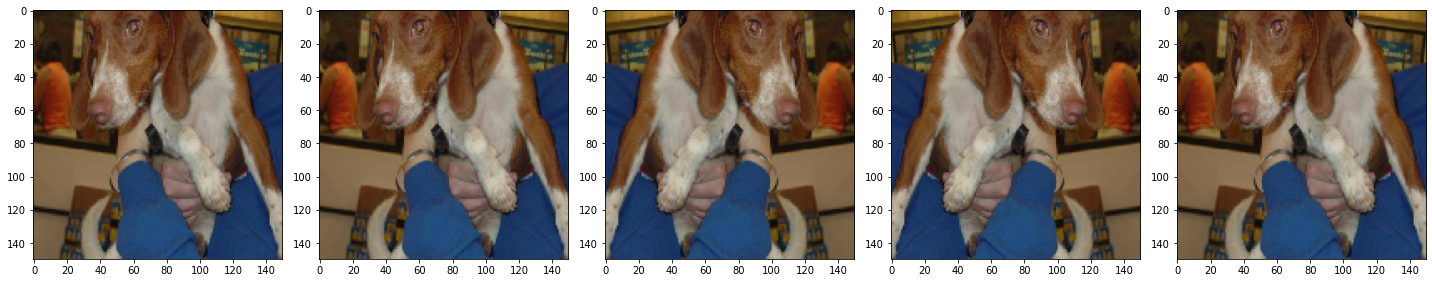

In [31]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Rotating the image
-------------------
The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [32]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's once again take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

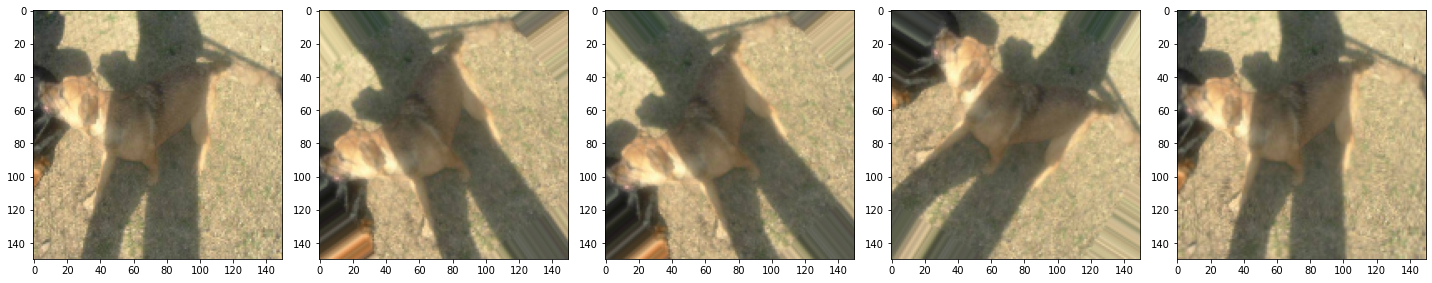

In [33]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
Applying Zoom
---------------
We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

In [35]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


Found 2000 images belonging to 2 classes.


One more time, take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

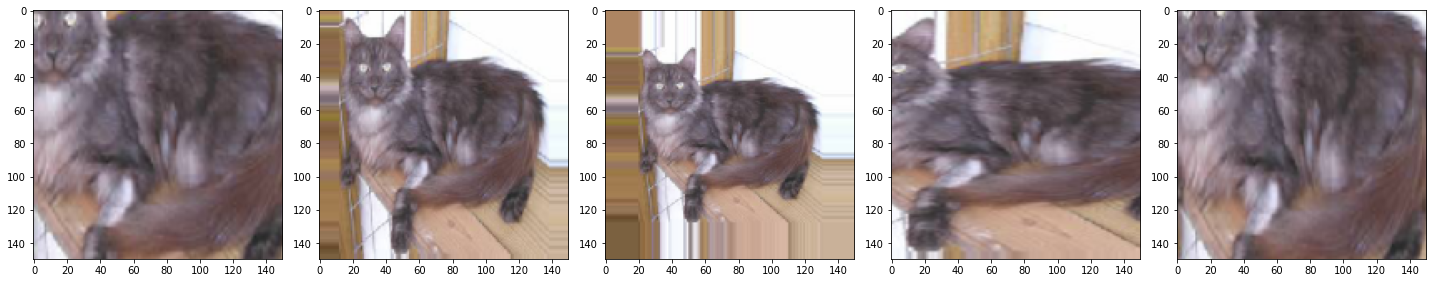

In [36]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Putting it all together - horizontal flipping, rotating, zoom techniques
-------------------------------------------------------------------------

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.


In [37]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset. 

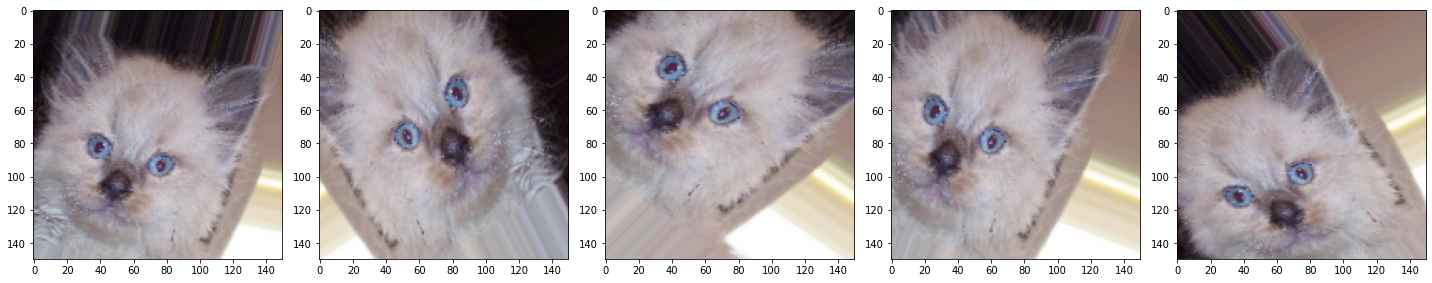

In [38]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Creating Validation Data generator
------------------------------------
Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.


In [39]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


Model Creation 
-----------------
Define the model - with Drop Out layer
-----------------------------------------
The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

Compiling the model
-------------------------
As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model Summary
-------------------
Let's look at all the layers of our network using **summary** method.

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

Train the model
--------------------
It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [43]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 19s 957ms/step - loss: 0.7288 - accuracy: 0.5210 - val_loss: 0.6924 - val_accuracy: 0.5060
Epoch 2/100
20/20 [==============================] - 19s 953ms/step - loss: 0.6913 - accuracy: 0.5040 - val_loss: 0.6852 - val_accuracy: 0.6150
Epoch 3/100
20/20 [==============================] - 19s 964ms/step - loss: 0.6798 - accuracy: 0.5675 - val_loss: 0.6554 - val_accuracy: 0.6020
Epoch 4/100
20/20 [==============================] - 19s 967ms/step - loss: 0.6799 - accuracy: 0.5610 - val_loss: 0.6691 - val_accuracy: 0.5690
Epoch 5/100
20/20 [==============================] - 19s 961ms/step - loss: 0.6723 - accuracy: 0.5680 - val_loss: 0.6445 - val_accuracy: 0.6210
Epoch 6/100
20/20 [==============================] - 19s 963ms/step - loss: 0.6678 - accuracy: 0.5915 - val_loss: 0.6425 - val_accuracy: 0.6300
Epoch 7/100
20/20 [==============================] - 20s 976ms/step - loss: 0.6603 - accuracy: 0.5930 - val_loss: 0.6320 - val_accuracy:

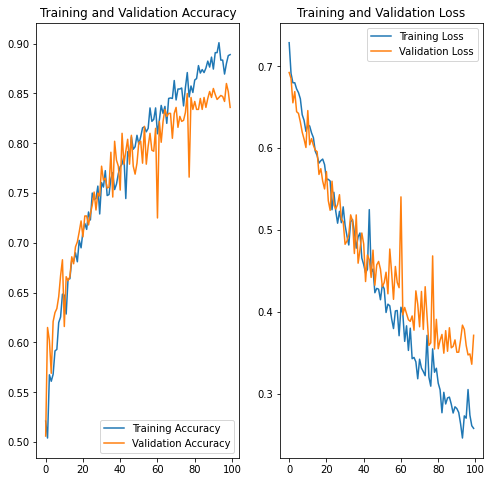

In [45]:
#Visualizing results of the training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()